In [2]:
import torch as t 
import torchvision
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import random

In [3]:
device = 'cuda' # cuda or cpu

In [4]:
batch_size = 64
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 0.1 # априорная дисперсия
epoch_num = 50 #количество эпох
lamb = [0, 0.1, 0.5, 1, 5, 10, 100, 1000]
# lam = 1.0 # коэффициент перед дивергенцией
hidden_num = 100 # количество нейронов на скрытом слое
t.manual_seed(42) # задаем значение генератора случайных чисел для повторяемости экспериментов
acc_delete = [] 
filename = 'Hypernet_lowrank_lamn50_sn3+1' # куда сохранять
lam_hidden_num = 50
start_num = 3
mode = 'lowrank'
lambda_sample_num = 5

In [5]:
# сохранение данных
def save(file):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()
    
def load(path = filename):
    infile = open(path, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file
    
    

In [26]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)


In [27]:
class LowRankNet(nn.Module):
    def __init__(self, size, hidden, gain_const = 1.0, gain_lamb = 1.0,
                 gain_lowrank = .0001,  act= F.relu):    
        nn.Module.__init__(self)        
        self.w = nn.Linear(1, hidden).to(device)
        t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
        # проверка на вектор или матрица
        if isinstance(size, tuple) and len(size) == 2: # если сайз неизменяемый список и его длина 2
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1,device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            self.w_d = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform(self.w_d.weight, gain_lowrank)
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 
            
        else:
            self.w_a1 = nn.Linear(hidden, self.in_).to(device)
            t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
            
            self.w_a2 = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
            
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const,  gain_const)
            
            
    def forward(self, lam):
        h = self.act(self.w(self.one * lam))        
        if self.diagonal:
            return self.const + self.w_d(h)
        else:
            a1 = self.w_a1(h)
            a2 = self.w_a2(h)
         
            return self.const +  t.matmul(a1.view(-1, 1), a2.view(1, -1))

        
class LinearApprNet(nn.Module):
    def __init__(self, size,  gain_const = 1.0, gain_const2 = 0.000001,  act= lambda x: x):    
        nn.Module.__init__(self)        
        if isinstance(size, tuple) and len(size) == 2:
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1, device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 
            self.const2 = nn.Parameter(t.ones(self.out_, device=device) * gain_const2) 
            
            
        else:
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const,  gain_const)
            self.const2 = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const2,  gain_const2)
            
            
    def forward(self, lam):        
        if self.diagonal:
            return self.const + self.const2 * lam
        else:
            return self.const + self.const2 * lam 
                

In [28]:
# проверка что все работает
# случай вектора
n = LowRankNet(100, 10)
n(100)- n(0)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


tensor([ 1.1579e-03,  4.4358e-04, -3.1865e-04,  3.2437e-04,  9.0420e-05,
         3.2893e-04,  4.0364e-04,  8.0103e-04,  3.8385e-04, -1.4532e-04,
         9.3460e-05, -8.5342e-04, -4.9203e-04,  1.0955e-03,  2.6686e-04,
        -5.0107e-04, -6.9356e-04, -3.5524e-05,  1.4722e-04, -4.9192e-04,
         1.3196e-04,  7.8094e-04, -5.0154e-04,  3.7491e-04, -7.2670e-04,
        -4.2802e-04, -2.1482e-04, -6.1572e-05,  7.6455e-04, -8.5819e-04,
        -5.1409e-04, -3.8001e-04, -2.3258e-04, -5.6469e-04, -4.0627e-04,
        -3.2903e-04,  1.0856e-03, -8.3484e-04, -9.5175e-04,  6.8972e-04,
         1.2767e-04, -1.1337e-03,  3.4571e-04,  6.0070e-04,  5.2279e-04,
        -3.9132e-04, -1.2994e-04, -1.7625e-04,  7.2122e-06, -2.2772e-04,
        -2.9835e-04, -1.7881e-07,  6.0558e-04,  4.9710e-05,  6.5863e-04,
         7.4020e-04,  2.1636e-04,  2.3735e-04,  4.2582e-04,  1.0834e-03,
        -4.0892e-04, -7.6619e-04, -2.2078e-04,  4.9284e-04, -5.7805e-04,
         9.3067e-04,  1.1504e-04,  5.8293e-04, -4.3

In [29]:
# проверка что все работает
# случай матрицы
n = LowRankNet((100, 20), 10)
n(100) - n(0)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


tensor([[-6.1625e-04,  4.0583e-04, -6.5077e-05,  ...,  3.8743e-07,
          3.6196e-04,  3.4638e-04],
        [ 6.1025e-04, -4.2704e-04, -5.9105e-05,  ..., -2.4839e-04,
         -5.2603e-04, -4.3452e-05],
        [-5.3713e-04,  3.5816e-04, -3.5007e-05,  ...,  4.3936e-05,
          3.4495e-04,  2.4928e-04],
        ...,
        [-6.3423e-04,  4.0828e-04, -1.1307e-04,  ..., -9.2089e-05,
          3.1003e-04,  4.6821e-04],
        [ 6.0985e-04, -4.0704e-04,  3.7774e-05,  ..., -5.3838e-05,
         -3.9433e-04, -2.7824e-04],
        [ 8.3520e-04, -5.5788e-04,  4.9610e-05,  ..., -7.7993e-05,
         -5.4292e-04, -3.7590e-04]], device='cuda:0', grad_fn=<SubBackward0>)

In [30]:
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_, device=device)) # параметры средних
        t.nn.init.xavier_uniform(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_, device = device)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_, device=device)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_, device=device) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b,  t.exp(self.log_sigma_b))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    
class VarLayerLowRank(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LowRankNet((in_, out_), lam_hidden_num) # параметры средних            
        self.log_sigma = LowRankNet((in_, out_), lam_hidden_num) # логарифм дисперсии
        self.mean_b = LowRankNet( out_, lam_hidden_num) # то же самое для свободного коэффициента
        self.log_sigma_b = LowRankNet( out_, lam_hidden_num)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    

class VarLayerLinearAppr(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LinearApprNet((in_, out_)) # параметры средних            
        self.log_sigma = LinearApprNet((in_, out_)) # логарифм дисперсии
        self.mean_b = LinearApprNet( out_) # то же самое для свободного коэффициента
        self.log_sigma_b = LinearApprNet( out_)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self, x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2    

In [31]:
l = VarLayerLinearAppr(784, 10)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [32]:
l.log_sigma_b(100)

tensor([-2.9999, -2.9999, -2.9999, -2.9999, -2.9999, -2.9999, -2.9999, -2.9999,
        -2.9999, -2.9999], device='cuda:0', grad_fn=<AddBackward0>)

In [33]:
class VarSeqNet(nn.Sequential):    
    # класс-обертка на случай, если у нас многослойная нейронная сеть
    def KLD(self, lam = None):
        k = 0
        for l in self: 
            if lam is None:
                k+=l.KLD()
            else:
                k+=l.KLD(lam)
                
        return k
    
    def forward(self, x, lam = None):
        if lam is None:
            for l in self:
                x = l(x)
            return x
        else:
            for l in self:
                x = l(x, lam)
            return x
    


In [34]:
def train_batches(net, loss_fn, optimizer, i, out, out_loss, kld, loss, epoch, lam):
    for id, (x,y) in enumerate(train_loader):  
            id+=1
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()            
            optimizer.zero_grad() 
            loss[i] = 0 
            for _ in range(lambda_sample_num):
                if (mode == 'frank'):
                    lam_param = None
                else:
                    lam = np.random.uniform(0, 100)
                    lam_param = lam/100
                out[i] = net(x, lam_param)
                # правдоподобие должно суммироваться по всей обучающей выборке
                # в случае батчей - она приводится к тому же порядку 
                out_loss[i] = loss_fn(out[i], y)* len(train_data) 
                kld[i] =  net.KLD(lam_param) *lam
                loss[i] += (out_loss[i]+kld[i])       
            if id %100 == 0:           
                print ("Number of net:",i, loss[i].data, out_loss[i].data, kld[i].data, lam)            

            
            loss[i].backward()       
            clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
            optimizer.step()

In [35]:
def statistic(net, loss_fn, i, kld, loss, out, out_loss):
    net.eval()  
    kld[i] =  net.KLD(1) 
    loss[i] = kld[i]
    for x,y in test_loader:
         if device == 'cuda':
            x = x.cuda()
            y = y.cuda()          
    out[i] = net(x, 1)   
    out_loss[i] = loss_fn(out[i], y)* len(train_data)
    #  print(out_loss[i])
    # print(loss[i])
    loss[i] += out_loss[i]
    net.train()
    print (loss[i])
    return loss[i]


    

In [36]:
# рассмотрим для примера сеть, состояющую из двух слоев
# второй слой - softmax. По сути для обучения задавать активацию явно не нужно, она забита в nn.CrossEntropyLoss
def init_nets(loss_fn_nets):
    for i in range(start_num):
        if mode == 'lowrank':
            nets.append(VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x)))
        elif mode == 'linear':
            nets.append(VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x)))
        else:
            raise ValueError('Bad mode')
        optimizer_nets.append(optim.SGD(nets[i].parameters(), lr=0.001))
        loss_fn_nets.append(nn.CrossEntropyLoss())
    loss_graph=[[],[],[]]
    out = [None, None, None]
    out_loss = [None, None, None]
    kld = [None, None, None]
    loss = [None, None, None]
    return out, out_loss, kld, loss, loss_graph

def train_nets(out, out_loss, kld, loss, loss_graph,l_frank):
    for epoch in range(epoch_num):             
        for i,net in enumerate(nets):
            train_batches(net,loss_fn_nets[i], optimizer_nets[i],i, out, out_loss, kld, loss, epoch, l_frank)
        print ('end of epoch: ', epoch)   
        for i,net in enumerate(nets):
            print("Number of net:",i)        
            #loss_graph[i].append(statistic(net, loss_fn_nets[i], i, kld, loss, out, out_loss))

        

In [37]:
#print(loss_graf)
def graph_loss_func(loss_graph, nets):
    for i,net in enumerate(nets): 
        plt.plot(loss_graph[i])
    plt.ylabel('Loss function')
    plt.xlabel('Number of epoche')
    plt.show()
#print(out_loss)

#graph_loss_func()

In [38]:
def test_acc(out): # точность классификации
    acc = []
    for i,net in enumerate(nets):
        correct = 0
        net.eval()
        for x,y in test_loader:
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()     
            out[i] = net(x)    
            correct += out[i].argmax(1).eq(y).sum().cpu().numpy()
        acc.append(correct / len(test_data))
    print(sum(acc)/len(acc))   
    return(acc)
#test_acc(out)

In [39]:
# коэффициенты информативности, см. статью practical variational inference
# попробуем удалять параметры первого слоя по этому коэффициенту

def init_coeff(prune_coef, mu, sigma):
    for i,net in enumerate(nets): 
        mu.append(net[0].mean) 
        sigma.append(t.exp(2*net[0].log_sigma))
        prune_coef.append((mu[i]**2/sigma[i]).cpu().detach().numpy())  


In [40]:
# будем удалять по 10% от модели и смотреть качество
def delete_10(acc_delete, prune_coef, mu, sigma, nets, out):
    acc_delete = []
    sorted_coefs = []
    for i, net in enumerate(nets):
        sorted_coefs.append(np.sort(prune_coef[i].flatten()))
    for j in range(10):
        for i,net in enumerate(nets): 
            ids = (prune_coef[i] <= sorted_coefs[i][round(j/10*len(sorted_coefs[i]))]) 
            net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
            print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        acc_delete.append(test_acc(out))
    return acc_delete    


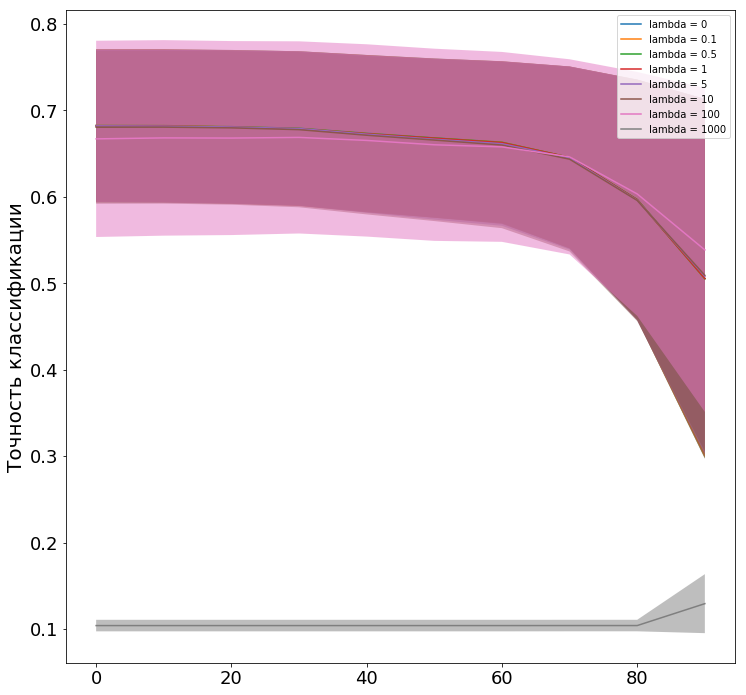

In [7]:
def graph(acc_delete, lamb):
    proc = [0,10,20,30,40,50,60,70,80,90]
    plt.rcParams['figure.figsize'] = 12, 12
    for k, lam in enumerate(lamb):
        acc_delete_n = np.array(acc_delete[k])
        plt.plot(proc, np.mean(acc_delete_n, 1), label = 'lambda = {}'.format(str(lam)))
        # откладываем ошибку вокруг среднего, альфа - прозрачность линии
        plt.fill_between(proc, np.mean(acc_delete_n, 1)  + np.std(acc_delete_n, 1) , np.mean(acc_delete_n, 1) - np.std(acc_delete_n, 1) , alpha = 0.5 )
    plt.ylabel('Точность классификации', fontsize = 20)
    plt.xlabel('Процент удаления', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(loc='best')
    plt.savefig('Lowrank_lamn50_sn3+1')
    plt.show()

#acc_delete = load('Hypernet_lowrank_lamn50_x')    
#graph(acc_delete, lamb)


    

In [42]:
# проверяем, что фокусов тут нет, удаляем оставшиеся 10%\
def delete_last10():
    flag = 0
    for j in range(10):
        for i,net in enumerate(nets): 
            if (flag == 0):
                sorted_coefs = np.sort(prune_coef[i].flatten())
                flag = 1
            ids = (prune_coef[i] <= sorted_coefs[round((0.9+j/100)*len(sorted_coefs))]) 
            net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
            print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        (test_acc())
    for i,net in enumerate(nets):
        net[0].mean.data*=0
        print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
    (test_acc())
    
#delete_last10()    

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Number of net: 0 tensor(1148767.7500, device='cuda:0') tensor(57993.9531, device='cuda:0') tensor(323783.3750, device='cuda:0') 92.69065717210322
Number of net: 0 tensor(990068.4375, device='cuda:0') tensor(86628.1953, device='cuda:0') tensor(86359.4922, device='cuda:0') 48.09816498743849
Number of net: 0 tensor(766154., device='cuda:0') tensor(123490.6172, device='cuda:0') tensor(38174.2578, device='cuda:0') 26.69426281046905
Number of net: 0 tensor(732487.0625, device='cuda:0') tensor(79299.7188, device='cuda:0') tensor(74016.9062, device='cuda:0') 61.94253532003371
Number of net: 0 tensor(817333.7500, device='cuda:0') tensor(106038.3750, device='cuda:0') tensor(105132.1641, device='cuda:0') 99.46528694908872
Number of net: 0 tensor(619506.1250, device='cuda:0') tensor(83354.1875, device='cuda:0') tensor(9978.5928, device='cuda:0') 8.017214205090417
Number of net: 0 tensor(692995.1250, device='cuda:0') tensor(73073.0938, device='cuda:0') tensor(14362.7578, device='cuda:0') 11.6946988

Number of net: 0 tensor(718861.6875, device='cuda:0') tensor(95883.1094, device='cuda:0') tensor(60002.5625, device='cuda:0') 62.43459450036776
Number of net: 0 tensor(723684.5625, device='cuda:0') tensor(53145.6172, device='cuda:0') tensor(50809.4570, device='cuda:0') 53.19305251744121
Number of net: 0 tensor(478019.2188, device='cuda:0') tensor(71149.2656, device='cuda:0') tensor(7949.8179, device='cuda:0') 6.35170493066245
Number of net: 0 tensor(765385.5625, device='cuda:0') tensor(72766.0547, device='cuda:0') tensor(46287.1367, device='cuda:0') 46.906272376657924
Number of net: 0 tensor(578138.5625, device='cuda:0') tensor(69808.5547, device='cuda:0') tensor(10206.5654, device='cuda:0') 7.903716086376789
Number of net: 0 tensor(556228.7500, device='cuda:0') tensor(70005.3516, device='cuda:0') tensor(72592.8438, device='cuda:0') 80.00925004885089
Number of net: 0 tensor(433193.6875, device='cuda:0') tensor(40159.3125, device='cuda:0') tensor(63610.0117, device='cuda:0') 68.64891858

Number of net: 0 tensor(603520.2500, device='cuda:0') tensor(73355.5156, device='cuda:0') tensor(40874.3242, device='cuda:0') 39.625821697790286
Number of net: 0 tensor(623541.7500, device='cuda:0') tensor(81406.4062, device='cuda:0') tensor(57301.0703, device='cuda:0') 59.54225814072775
Number of net: 0 tensor(684777.7500, device='cuda:0') tensor(52241.9648, device='cuda:0') tensor(45950.5625, device='cuda:0') 45.442787862950205
Number of net: 0 tensor(700602.6250, device='cuda:0') tensor(78779.0938, device='cuda:0') tensor(61131.4336, device='cuda:0') 65.04905707056905
Number of net: 0 tensor(414748.9688, device='cuda:0') tensor(37391.9453, device='cuda:0') tensor(2523.6436, device='cuda:0') 1.5909250009190523
Number of net: 1 tensor(425968.3125, device='cuda:0') tensor(52262.8945, device='cuda:0') tensor(56171.4336, device='cuda:0') 55.21572764907149
Number of net: 1 tensor(670968.9375, device='cuda:0') tensor(42114.0664, device='cuda:0') tensor(27569.1172, device='cuda:0') 22.91482

Number of net: 0 tensor(621750.8750, device='cuda:0') tensor(74330.5391, device='cuda:0') tensor(48721.7227, device='cuda:0') 44.2258070281644
Number of net: 0 tensor(503522.1250, device='cuda:0') tensor(89791.6406, device='cuda:0') tensor(38529.1406, device='cuda:0') 33.335330766991575
Number of net: 0 tensor(573345.0625, device='cuda:0') tensor(43394.7656, device='cuda:0') tensor(6521.7612, device='cuda:0') 4.268725272620911
Number of net: 1 tensor(597099.9375, device='cuda:0') tensor(44674.8008, device='cuda:0') tensor(63955.6875, device='cuda:0') 65.91528112412655
Number of net: 1 tensor(439366.1562, device='cuda:0') tensor(65419.6875, device='cuda:0') tensor(26475.5059, device='cuda:0') 20.21960334088272
Number of net: 1 tensor(597012.9375, device='cuda:0') tensor(79087.4062, device='cuda:0') tensor(13876.8613, device='cuda:0') 9.000041099467982
Number of net: 1 tensor(584235.4375, device='cuda:0') tensor(76863.5938, device='cuda:0') tensor(38152.2891, device='cuda:0') 32.85223535

Number of net: 1 tensor(705395.3125, device='cuda:0') tensor(52204.2266, device='cuda:0') tensor(57952.4531, device='cuda:0') 50.88773054514775
Number of net: 1 tensor(723637., device='cuda:0') tensor(89072.8438, device='cuda:0') tensor(73582.8750, device='cuda:0') 67.08576859729743
Number of net: 1 tensor(526627.3750, device='cuda:0') tensor(77681.5312, device='cuda:0') tensor(10742.0996, device='cuda:0') 7.272852142154362
Number of net: 1 tensor(692733.5625, device='cuda:0') tensor(80194.6172, device='cuda:0') tensor(78571.7734, device='cuda:0') 66.1715796809361
Number of net: 1 tensor(831929.2500, device='cuda:0') tensor(125158.7656, device='cuda:0') tensor(81345.6953, device='cuda:0') 62.27803962783881
Number of net: 1 tensor(875689.3750, device='cuda:0') tensor(93950.9922, device='cuda:0') tensor(123041.7891, device='cuda:0') 90.77443386426883
Number of net: 1 tensor(765820.3750, device='cuda:0') tensor(61310.5977, device='cuda:0') tensor(12356.3330, device='cuda:0') 7.05036558137

Number of net: 1 tensor(1340924.8750, device='cuda:0') tensor(181538.5938, device='cuda:0') tensor(120523.5078, device='cuda:0') 55.257800695988244
Number of net: 1 tensor(1190554.1250, device='cuda:0') tensor(146962.4375, device='cuda:0') tensor(62277.8398, device='cuda:0') 26.808767362828412
Number of net: 1 tensor(1407667.8750, device='cuda:0') tensor(82962.2656, device='cuda:0') tensor(148566.8438, device='cuda:0') 71.1989873627631
Number of net: 1 tensor(1438422.7500, device='cuda:0') tensor(129000.4062, device='cuda:0') tensor(107127.2734, device='cuda:0') 43.50923007252403
Number of net: 1 tensor(1232291.8750, device='cuda:0') tensor(94959.6250, device='cuda:0') tensor(79567.8828, device='cuda:0') 34.0471917219481
Number of net: 1 tensor(1253126.5000, device='cuda:0') tensor(114390.7500, device='cuda:0') tensor(150944.5312, device='cuda:0') 60.94746547444121
Number of net: 2 tensor(52801720., device='cuda:0') tensor(3081692., device='cuda:0') tensor(5758163.5000, device='cuda:0'

Number of net: 1 tensor(988146.7500, device='cuda:0') tensor(44647.5234, device='cuda:0') tensor(159876.3438, device='cuda:0') 81.9722128218342
Number of net: 1 tensor(1281065., device='cuda:0') tensor(146142.1875, device='cuda:0') tensor(87521., device='cuda:0') 36.500476787149886
Number of net: 1 tensor(1370228.5000, device='cuda:0') tensor(63846.7461, device='cuda:0') tensor(99163.1172, device='cuda:0') 37.01164361654878
Number of net: 2 tensor(96318232., device='cuda:0') tensor(4594618.5000, device='cuda:0') tensor(13157294., device='cuda:0') 81.90726442776038
Number of net: 2 tensor(77528472., device='cuda:0') tensor(9725841., device='cuda:0') tensor(6077427., device='cuda:0') 37.040220174187525
Number of net: 2 tensor(57492592., device='cuda:0') tensor(2062834.1250, device='cuda:0') tensor(9632676., device='cuda:0') 57.59212062072893
Number of net: 2 tensor(68308904., device='cuda:0') tensor(3123382.5000, device='cuda:0') tensor(8471798., device='cuda:0') 47.102797627422454
Numbe

Number of net: 1 tensor(1041331.5000, device='cuda:0') tensor(234029.1562, device='cuda:0') tensor(6399.9194, device='cuda:0') 1.7178193994246915
Number of net: 2 tensor(1.4161e+08, device='cuda:0') tensor(44419988., device='cuda:0') tensor(62478.7695, device='cuda:0') 0.11505223157197708
Number of net: 2 tensor(98524912., device='cuda:0') tensor(9784854., device='cuda:0') tensor(9466942., device='cuda:0') 36.7398410862573
Number of net: 2 tensor(90605688., device='cuda:0') tensor(7740615., device='cuda:0') tensor(11365839., device='cuda:0') 50.330238490548886
Number of net: 2 tensor(91446856., device='cuda:0') tensor(3409707.7500, device='cuda:0') tensor(22177048., device='cuda:0') 95.77476699980124
Number of net: 2 tensor(98108456., device='cuda:0') tensor(10985081., device='cuda:0') tensor(6017111.5000, device='cuda:0') 18.9631426387994
Number of net: 2 tensor(96502320., device='cuda:0') tensor(4766402., device='cuda:0') tensor(13728185., device='cuda:0') 64.12854658259698
Number of

Number of net: 2 tensor(1.5903e+08, device='cuda:0') tensor(15319462., device='cuda:0') tensor(17520994., device='cuda:0') 61.76567553221499
Number of net: 2 tensor(1.3804e+08, device='cuda:0') tensor(5208849., device='cuda:0') tensor(27520610., device='cuda:0') 83.95583109884399
Number of net: 2 tensor(1.5066e+08, device='cuda:0') tensor(4758565., device='cuda:0') tensor(31803026., device='cuda:0') 98.88204012192678
Number of net: 2 tensor(1.6019e+08, device='cuda:0') tensor(21844026., device='cuda:0') tensor(10244116., device='cuda:0') 28.316547488368283
Number of net: 2 tensor(93435512., device='cuda:0') tensor(10010735., device='cuda:0') tensor(3324736., device='cuda:0') 7.076693075614249
Number of net: 2 tensor(1.1975e+08, device='cuda:0') tensor(12145307., device='cuda:0') tensor(6530767.5000, device='cuda:0') 20.21515107503724
Number of net: 2 tensor(1.4799e+08, device='cuda:0') tensor(8181613., device='cuda:0') tensor(14285044., device='cuda:0') 44.406808893386106
Number of net

Number of net: 2 tensor(3.0110e+08, device='cuda:0') tensor(42390952., device='cuda:0') tensor(2565658.5000, device='cuda:0') 4.652630279910131
Number of net: 2 tensor(1.2583e+08, device='cuda:0') tensor(6971465., device='cuda:0') tensor(30214780., device='cuda:0') 79.78150519790205
Number of net: 2 tensor(1.7393e+08, device='cuda:0') tensor(14831656., device='cuda:0') tensor(10734361., device='cuda:0') 31.289219527608626
Number of net: 2 tensor(1.5736e+08, device='cuda:0') tensor(17236596., device='cuda:0') tensor(14814204., device='cuda:0') 36.956900461132
Number of net: 2 tensor(2.5722e+08, device='cuda:0') tensor(21482034., device='cuda:0') tensor(25962396., device='cuda:0') 52.678069226118986
end of epoch:  18
Number of net: 0
Number of net: 1
Number of net: 2
Number of net: 0 tensor(1971756., device='cuda:0') tensor(182093.9219, device='cuda:0') tensor(121886.3516, device='cuda:0') 23.096683728353895
Number of net: 0 tensor(2885958.5000, device='cuda:0') tensor(203302., device='c

Number of net: 2 tensor(1.8140e+08, device='cuda:0') tensor(24518376., device='cuda:0') tensor(6525585.5000, device='cuda:0') 12.555364329951658
Number of net: 2 tensor(2.5945e+08, device='cuda:0') tensor(22269686., device='cuda:0') tensor(27656552., device='cuda:0') 51.81495043910896
Number of net: 2 tensor(2.4219e+08, device='cuda:0') tensor(11122682., device='cuda:0') tensor(41174236., device='cuda:0') 73.67195793597672
end of epoch:  20
Number of net: 0
Number of net: 1
Number of net: 2
Number of net: 0 tensor(2588340.7500, device='cuda:0') tensor(141360.8906, device='cuda:0') tensor(274127.9062, device='cuda:0') 40.070001015185554
Number of net: 0 tensor(4292917., device='cuda:0') tensor(880427.3750, device='cuda:0') tensor(61922.6328, device='cuda:0') 6.467713195416458
Number of net: 0 tensor(5809877., device='cuda:0') tensor(378346.3438, device='cuda:0') tensor(541967.8750, device='cuda:0') 56.09214456163157
Number of net: 0 tensor(3129685.5000, device='cuda:0') tensor(227765.56

end of epoch:  22
Number of net: 0
Number of net: 1
Number of net: 2
Number of net: 0 tensor(7257840., device='cuda:0') tensor(489561.5312, device='cuda:0') tensor(561041.8750, device='cuda:0') 48.81254962177011
Number of net: 0 tensor(20083712., device='cuda:0') tensor(2500331.7500, device='cuda:0') tensor(1380331.8750, device='cuda:0') 87.76538012255801
Number of net: 0 tensor(11375916., device='cuda:0') tensor(2727760.5000, device='cuda:0') tensor(112769.4219, device='cuda:0') 7.690884228953565
Number of net: 0 tensor(5581297., device='cuda:0') tensor(210076., device='cuda:0') tensor(502893.7188, device='cuda:0') 41.2066664703569
Number of net: 0 tensor(9905026., device='cuda:0') tensor(992176.3125, device='cuda:0') tensor(965534.8750, device='cuda:0') 72.3923844843201
Number of net: 0 tensor(9979411., device='cuda:0') tensor(807623.6875, device='cuda:0') tensor(60065.5273, device='cuda:0') 3.6704962599352964
Number of net: 0 tensor(6524667., device='cuda:0') tensor(502721.6875, dev

Number of net: 0 tensor(8578289., device='cuda:0') tensor(521397.5000, device='cuda:0') tensor(1795556.3750, device='cuda:0') 96.50215291353025
Number of net: 0 tensor(35978112., device='cuda:0') tensor(6532504.5000, device='cuda:0') tensor(1314122.5000, device='cuda:0') 53.039717923057864
Number of net: 0 tensor(11470804., device='cuda:0') tensor(1406195., device='cuda:0') tensor(841194.7500, device='cuda:0') 42.28283370996985
Number of net: 0 tensor(16111650., device='cuda:0') tensor(3352982.7500, device='cuda:0') tensor(1978045.6250, device='cuda:0') 94.93633462606788
Number of net: 0 tensor(9041280., device='cuda:0') tensor(1136713., device='cuda:0') tensor(348514.5625, device='cuda:0') 17.925660329545835
Number of net: 0 tensor(16375650., device='cuda:0') tensor(1877161.8750, device='cuda:0') tensor(1560820.6250, device='cuda:0') 83.4186950613116
Number of net: 0 tensor(7396895.5000, device='cuda:0') tensor(625747.8125, device='cuda:0') tensor(1374649.2500, device='cuda:0') 74.751

Number of net: 0 tensor(14291113., device='cuda:0') tensor(1940274.3750, device='cuda:0') tensor(833790.6875, device='cuda:0') 30.39169214681644
Number of net: 0 tensor(34781964., device='cuda:0') tensor(4044253.7500, device='cuda:0') tensor(411462.1250, device='cuda:0') 12.015649377507732
Number of net: 0 tensor(1.1968e+08, device='cuda:0') tensor(17820620., device='cuda:0') tensor(4579971., device='cuda:0') 78.03616082246917
Number of net: 0 tensor(22628452., device='cuda:0') tensor(2710876., device='cuda:0') tensor(708889.0625, device='cuda:0') 20.428896648393913
Number of net: 1 tensor(1580700.2500, device='cuda:0') tensor(111263.8047, device='cuda:0') tensor(365113.5000, device='cuda:0') 84.3577780502533
Number of net: 1 tensor(1458875.7500, device='cuda:0') tensor(112471.0078, device='cuda:0') tensor(131960.5156, device='cuda:0') 36.30777721918693
Number of net: 1 tensor(1960625.6250, device='cuda:0') tensor(141492.0938, device='cuda:0') tensor(143987.3906, device='cuda:0') 25.55

Number of net: 0 tensor(15543274., device='cuda:0') tensor(786516.8125, device='cuda:0') tensor(989948.8750, device='cuda:0') 24.999592345021494
Number of net: 0 tensor(21675004., device='cuda:0') tensor(1424799.7500, device='cuda:0') tensor(1666839.7500, device='cuda:0') 41.525040535613044
Number of net: 1 tensor(2348701.2500, device='cuda:0') tensor(97555.3984, device='cuda:0') tensor(130109.8438, device='cuda:0') 25.033304441455606
Number of net: 1 tensor(3270353., device='cuda:0') tensor(350217.0312, device='cuda:0') tensor(397702.5938, device='cuda:0') 81.34140831320637
Number of net: 1 tensor(1957302.7500, device='cuda:0') tensor(103531.3438, device='cuda:0') tensor(319634.5938, device='cuda:0') 88.67247063028161
Number of net: 1 tensor(1902378., device='cuda:0') tensor(161260.3750, device='cuda:0') tensor(266354.6562, device='cuda:0') 58.4702762599804
Number of net: 1 tensor(2025781.8750, device='cuda:0') tensor(259321.1719, device='cuda:0') tensor(168074.4844, device='cuda:0') 

Number of net: 1 tensor(2624217.2500, device='cuda:0') tensor(194642.7188, device='cuda:0') tensor(153108.3750, device='cuda:0') 25.3125796382755
Number of net: 1 tensor(3373571.2500, device='cuda:0') tensor(441361.1562, device='cuda:0') tensor(229990.7969, device='cuda:0') 36.06679024487312
Number of net: 1 tensor(2900044.5000, device='cuda:0') tensor(438785.1250, device='cuda:0') tensor(497031.3438, device='cuda:0') 68.71269907187045
Number of net: 1 tensor(3038020.5000, device='cuda:0') tensor(269453.8438, device='cuda:0') tensor(734384.2500, device='cuda:0') 96.66310059841592
Number of net: 1 tensor(2759372., device='cuda:0') tensor(281817.6875, device='cuda:0') tensor(352533.0312, device='cuda:0') 64.735617949772
Number of net: 1 tensor(8243281., device='cuda:0') tensor(1177693.2500, device='cuda:0') tensor(139661.1250, device='cuda:0') 15.114775749179099
Number of net: 1 tensor(4156719.7500, device='cuda:0') tensor(277930.5625, device='cuda:0') tensor(555045.1250, device='cuda:0'

Number of net: 1 tensor(2625169.7500, device='cuda:0') tensor(273511.5312, device='cuda:0') tensor(481957.7812, device='cuda:0') 80.79838427615343
Number of net: 1 tensor(3692751.5000, device='cuda:0') tensor(709532.3125, device='cuda:0') tensor(331455.5312, device='cuda:0') 39.44647777035719
Number of net: 1 tensor(15665873., device='cuda:0') tensor(1992545.2500, device='cuda:0') tensor(555794.5000, device='cuda:0') 52.76489104531385
Number of net: 1 tensor(9140859., device='cuda:0') tensor(340988.5312, device='cuda:0') tensor(1094496.7500, device='cuda:0') 94.79468736935867
Number of net: 1 tensor(2415077.7500, device='cuda:0') tensor(200226.7500, device='cuda:0') tensor(145126.0469, device='cuda:0') 21.562553920104488
Number of net: 2 tensor(5.7026e+08, device='cuda:0') tensor(35201620., device='cuda:0') tensor(11424090., device='cuda:0') 8.344672048769464
Number of net: 2 tensor(5.1662e+08, device='cuda:0') tensor(75835632., device='cuda:0') tensor(50696648., device='cuda:0') 41.06

Number of net: 1 tensor(2792664.5000, device='cuda:0') tensor(185614.2188, device='cuda:0') tensor(497020.3125, device='cuda:0') 92.10186024291698
Number of net: 1 tensor(3988415.2500, device='cuda:0') tensor(585771.9375, device='cuda:0') tensor(632752.1250, device='cuda:0') 76.57883843546304
Number of net: 2 tensor(3.6917e+08, device='cuda:0') tensor(24769376., device='cuda:0') tensor(80801528., device='cuda:0') 66.91287351753803
Number of net: 2 tensor(4.5341e+08, device='cuda:0') tensor(22253718., device='cuda:0') tensor(78201360., device='cuda:0') 66.40917628747661
Number of net: 2 tensor(3.5162e+08, device='cuda:0') tensor(25472148., device='cuda:0') tensor(1736884.5000, device='cuda:0') 1.3013597766013074
Number of net: 2 tensor(7.0254e+08, device='cuda:0') tensor(50275516., device='cuda:0') tensor(90721328., device='cuda:0') 75.47430966086559
Number of net: 2 tensor(4.6415e+08, device='cuda:0') tensor(25909964., device='cuda:0') tensor(33045110., device='cuda:0') 26.707293930096

Number of net: 2 tensor(4.0206e+08, device='cuda:0') tensor(22506640., device='cuda:0') tensor(66496196., device='cuda:0') 49.66433382952715
Number of net: 2 tensor(8.2241e+08, device='cuda:0') tensor(64753404., device='cuda:0') tensor(86936504., device='cuda:0') 64.75899788740959
Number of net: 2 tensor(1.0184e+09, device='cuda:0') tensor(1.2790e+08, device='cuda:0') tensor(1.3050e+08, device='cuda:0') 86.72799394282642
Number of net: 2 tensor(1.0756e+09, device='cuda:0') tensor(68091840., device='cuda:0') tensor(1.4084e+08, device='cuda:0') 93.75892186628411
Number of net: 2 tensor(5.9118e+08, device='cuda:0') tensor(40461564., device='cuda:0') tensor(1.0534e+08, device='cuda:0') 78.3616806713079
Number of net: 2 tensor(5.4207e+08, device='cuda:0') tensor(60565612., device='cuda:0') tensor(84818776., device='cuda:0') 57.98799083226709
Number of net: 2 tensor(5.0693e+08, device='cuda:0') tensor(28916398., device='cuda:0') tensor(98354544., device='cuda:0') 79.0313087935744
Number of n

Number of net: 2 tensor(5.2564e+08, device='cuda:0') tensor(50044820., device='cuda:0') tensor(42872248., device='cuda:0') 31.181953639645144
Number of net: 2 tensor(5.4699e+08, device='cuda:0') tensor(19168374., device='cuda:0') tensor(65386076., device='cuda:0') 48.25995634251946
Number of net: 2 tensor(6.1196e+08, device='cuda:0') tensor(51593448., device='cuda:0') tensor(19196774., device='cuda:0') 13.2861432546172
Number of net: 2 tensor(4.5912e+08, device='cuda:0') tensor(73276992., device='cuda:0') tensor(1.1560e+08, device='cuda:0') 87.01203695348988
Number of net: 2 tensor(5.4443e+08, device='cuda:0') tensor(25580822., device='cuda:0') tensor(41043392., device='cuda:0') 26.738553645942996
end of epoch:  39
Number of net: 0
Number of net: 1
Number of net: 2
Number of net: 0 tensor(83342360., device='cuda:0') tensor(3315642.5000, device='cuda:0') tensor(13107067., device='cuda:0') 80.46297531607154
Number of net: 0 tensor(52964824., device='cuda:0') tensor(3999593.7500, device='

Number of net: 2 tensor(5.3240e+08, device='cuda:0') tensor(52540784., device='cuda:0') tensor(33218800., device='cuda:0') 26.94791217777378
Number of net: 2 tensor(4.6831e+08, device='cuda:0') tensor(43027328., device='cuda:0') tensor(17596532., device='cuda:0') 12.085560217719705
end of epoch:  41
Number of net: 0
Number of net: 1
Number of net: 2
Number of net: 0 tensor(1.1548e+08, device='cuda:0') tensor(21297646., device='cuda:0') tensor(9852706., device='cuda:0') 47.117312396655386
Number of net: 0 tensor(1.7420e+08, device='cuda:0') tensor(35880380., device='cuda:0') tensor(514346.4688, device='cuda:0') 2.1397138389628423
Number of net: 0 tensor(3.0293e+08, device='cuda:0') tensor(46033344., device='cuda:0') tensor(1918680.2500, device='cuda:0') 7.930474981203273
Number of net: 0 tensor(1.0983e+08, device='cuda:0') tensor(11230816., device='cuda:0') tensor(304464., device='cuda:0') 1.2613202558287573
Number of net: 0 tensor(2.1795e+08, device='cuda:0') tensor(54195092., device='

Number of net: 0 tensor(1.1713e+08, device='cuda:0') tensor(10752526., device='cuda:0') tensor(9791149., device='cuda:0') 37.8632621104904
Number of net: 0 tensor(6.1960e+08, device='cuda:0') tensor(78495288., device='cuda:0') tensor(16317442., device='cuda:0') 49.06743887546609
Number of net: 0 tensor(1.7009e+08, device='cuda:0') tensor(31715860., device='cuda:0') tensor(23844016., device='cuda:0') 92.94977198595005
Number of net: 0 tensor(1.1027e+08, device='cuda:0') tensor(18617820., device='cuda:0') tensor(19114730., device='cuda:0') 81.35489730993268
Number of net: 0 tensor(2.3641e+08, device='cuda:0') tensor(24130396., device='cuda:0') tensor(2840206.5000, device='cuda:0') 8.749956942004179
Number of net: 0 tensor(1.2339e+08, device='cuda:0') tensor(6057636.5000, device='cuda:0') tensor(17746782., device='cuda:0') 77.02609280215714
Number of net: 0 tensor(1.9217e+08, device='cuda:0') tensor(28647798., device='cuda:0') tensor(15221158., device='cuda:0') 59.09417959279928
Number of

Number of net: 0 tensor(1.7802e+08, device='cuda:0') tensor(20050222., device='cuda:0') tensor(26013504., device='cuda:0') 90.09422077442211
Number of net: 0 tensor(2.0755e+08, device='cuda:0') tensor(13529064., device='cuda:0') tensor(12604233., device='cuda:0') 43.00410753339944
Number of net: 0 tensor(3.6868e+08, device='cuda:0') tensor(39096800., device='cuda:0') tensor(6923210.5000, device='cuda:0') 18.231701448793324
Number of net: 0 tensor(1.7757e+08, device='cuda:0') tensor(21673126., device='cuda:0') tensor(12679917., device='cuda:0') 36.2538790345713
Number of net: 0 tensor(3.5292e+08, device='cuda:0') tensor(53197332., device='cuda:0') tensor(7765251.5000, device='cuda:0') 21.812846566453214
Number of net: 0 tensor(2.5398e+08, device='cuda:0') tensor(25426468., device='cuda:0') tensor(16513029., device='cuda:0') 54.678578307783
Number of net: 1 tensor(8413995., device='cuda:0') tensor(750836.5625, device='cuda:0') tensor(80623.1641, device='cuda:0') 3.3296747997877407
Number

Number of net: 0 tensor(1.3270e+08, device='cuda:0') tensor(8534957., device='cuda:0') tensor(9050247., device='cuda:0') 22.911485129875665
Number of net: 0 tensor(2.3627e+08, device='cuda:0') tensor(26402538., device='cuda:0') tensor(23967946., device='cuda:0') 70.48417888419391
Number of net: 0 tensor(1.3208e+08, device='cuda:0') tensor(17080180., device='cuda:0') tensor(15103506., device='cuda:0') 42.45685985081747
Number of net: 1 tensor(3588433., device='cuda:0') tensor(426029.8750, device='cuda:0') tensor(18866.4844, device='cuda:0') 1.764755848384325
Number of net: 1 tensor(5851153., device='cuda:0') tensor(571007.8125, device='cuda:0') tensor(241428.8281, device='cuda:0') 13.818718751329595
Number of net: 1 tensor(12307202., device='cuda:0') tensor(2619870.5000, device='cuda:0') tensor(1872741., device='cuda:0') 91.34037767473878
Number of net: 1 tensor(6087431.5000, device='cuda:0') tensor(814731.7500, device='cuda:0') tensor(532952.8125, device='cuda:0') 43.68919292161372
Num

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


0.6826666666666666
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
0.6824
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
0.6811666666666666
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
0.6793
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
0.6735000000000001
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
0.6680999999999999
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
0.6632
nonzero params:  tens

0.6806333333333333
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
0.6797999999999998
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
0.6777333333333333
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
0.6712666666666666
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
0.6656666666666667
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
0.6599333333333334
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
0.64

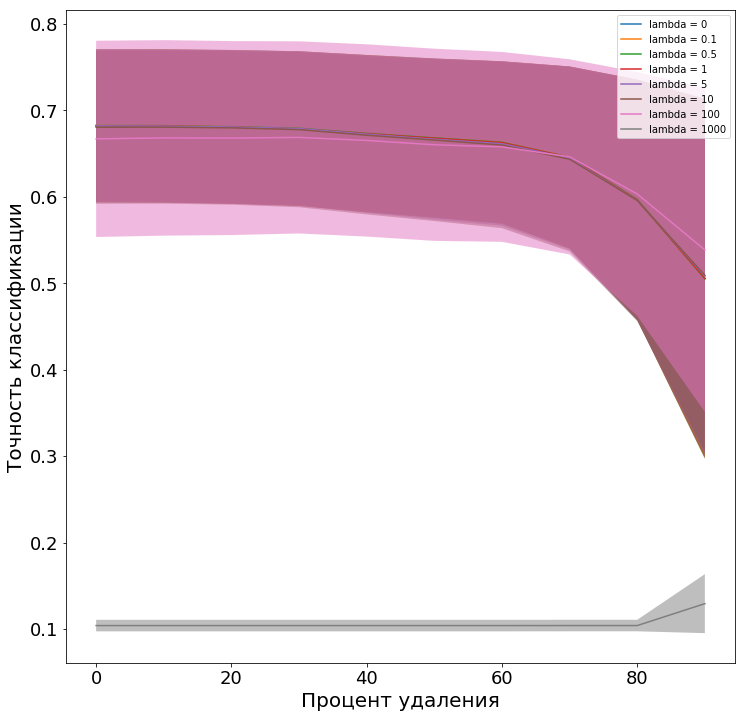

In [48]:
loss_fn_nets =[]
nets = []
optimizer_nets = []
mu_glob = []
sigma_glob = []
prune_coef_glob = []
init_nets_output =  init_nets(loss_fn_nets)
train_nets(init_nets_output[0], init_nets_output[1], init_nets_output[2], init_nets_output[3], init_nets_output[4], None)
old_nets = nets[:]

for k,lam in enumerate(lamb):
    for i, net in enumerate(nets):
        new_net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
        for j in range(0, 2): # бежим по слоям
            lam_param = lam / 100
            new_net[j].mean.data*=0
            new_net[j].mean.data+=old_nets[i][j].mean(lam_param)
            new_net[j].mean_b.data*=0
            new_net[j].mean_b.data+=old_nets[i][j].mean_b(lam_param)
            new_net[j].log_sigma.data*=0
            new_net[j].log_sigma.data+=old_nets[i][j].log_sigma(lam_param)
            new_net[j].log_sigma_b.data*=0
            new_net[j].log_sigma_b.data+=old_nets[i][j].log_sigma_b(lam_param)
            
        nets[i] = new_net        
    acc_delete.append(None)
    init_coeff(prune_coef_glob, mu_glob, sigma_glob)
    acc_delete[k]= delete_10(acc_delete[k], prune_coef_glob, mu_glob, sigma_glob, nets, init_nets_output[0])

    
init_coeff(prune_coef_glob, mu_glob, sigma_glob)    
#graph_loss_func()
graph(acc_delete,lamb)
save(acc_delete)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


0.6826666666666666
[0.6654, 0.7981, 0.5845]
Number of net: 0 tensor(2817230.5000, device='cuda:0') tensor(2817230.5000, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(4910514., device='cuda:0') tensor(4910514., device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(3628761.2500, device='cuda:0') tensor(3628761.2500, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(3167724.5000, device='cuda:0') tensor(3167724.5000, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(1372277.5000, device='cuda:0') tensor(1372277.5000, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(3680447.5000, device='cuda:0') tensor(3680447.5000, device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(2858876., device='cuda:0') tensor(2858876., device='cuda:0') tensor(0., device='cuda:0') 0
Number of net: 0 tensor(4523466., device='cuda:0') tensor(4523466., device='cuda:0') tensor(0., device='cuda:0'

Number of net: 2 tensor(3730679.5000, device='cuda:0') tensor(3587190., device='cuda:0') tensor(143489.5938, device='cuda:0') 0.1
Number of net: 2 tensor(2395432.5000, device='cuda:0') tensor(2251538., device='cuda:0') tensor(143894.6250, device='cuda:0') 0.1
end of epoch:  0
Number of net: 0
Number of net: 1
Number of net: 2
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(1.0000, device='cuda:0')
0.8627333333333332
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
0.8612333333333333
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
0.8552333333333332
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
0.8480666666666666
nonzero 

Number of net: 0 tensor(4929643.5000, device='cuda:0') tensor(4492688.5000, device='cuda:0') tensor(436955., device='cuda:0') 1
Number of net: 0 tensor(1802862.5000, device='cuda:0') tensor(1371481., device='cuda:0') tensor(431381.4375, device='cuda:0') 1
Number of net: 1 tensor(48429.8320, device='cuda:0') tensor(33935.1602, device='cuda:0') tensor(14494.6719, device='cuda:0') 1
Number of net: 1 tensor(70718., device='cuda:0') tensor(57840.2500, device='cuda:0') tensor(12877.7490, device='cuda:0') 1
Number of net: 1 tensor(68001.3828, device='cuda:0') tensor(56524.2656, device='cuda:0') tensor(11477.1182, device='cuda:0') 1
Number of net: 1 tensor(77948.3984, device='cuda:0') tensor(67655.6172, device='cuda:0') tensor(10292.7842, device='cuda:0') 1
Number of net: 1 tensor(43803.4258, device='cuda:0') tensor(34488.4258, device='cuda:0') tensor(9315., device='cuda:0') 1
Number of net: 1 tensor(38602.5586, device='cuda:0') tensor(30154.6172, device='cuda:0') tensor(8447.9404, device='cud

0.8589000000000001
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
0.8529
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
0.8436333333333333
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
0.8316333333333333
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
0.8234
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
0.7920333333333334
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
0.7256666666666667
nonzero p

Number of net: 1 tensor(351260.7188, device='cuda:0') tensor(35938.7539, device='cuda:0') tensor(315321.9688, device='cuda:0') 100
Number of net: 1 tensor(303706.3125, device='cuda:0') tensor(40601.8945, device='cuda:0') tensor(263104.4062, device='cuda:0') 100
Number of net: 1 tensor(249872.9375, device='cuda:0') tensor(29583.9258, device='cuda:0') tensor(220289.0156, device='cuda:0') 100
Number of net: 2 tensor(1.2496e+08, device='cuda:0') tensor(1086763.8750, device='cuda:0') tensor(1.2388e+08, device='cuda:0') 100
Number of net: 2 tensor(1.1818e+08, device='cuda:0') tensor(1973408.2500, device='cuda:0') tensor(1.1620e+08, device='cuda:0') 100
Number of net: 2 tensor(1.1278e+08, device='cuda:0') tensor(1810933.2500, device='cuda:0') tensor(1.1097e+08, device='cuda:0') 100
Number of net: 2 tensor(1.0883e+08, device='cuda:0') tensor(2152604.2500, device='cuda:0') tensor(1.0667e+08, device='cuda:0') 100
Number of net: 2 tensor(1.0400e+08, device='cuda:0') tensor(808227.5625, device='cu

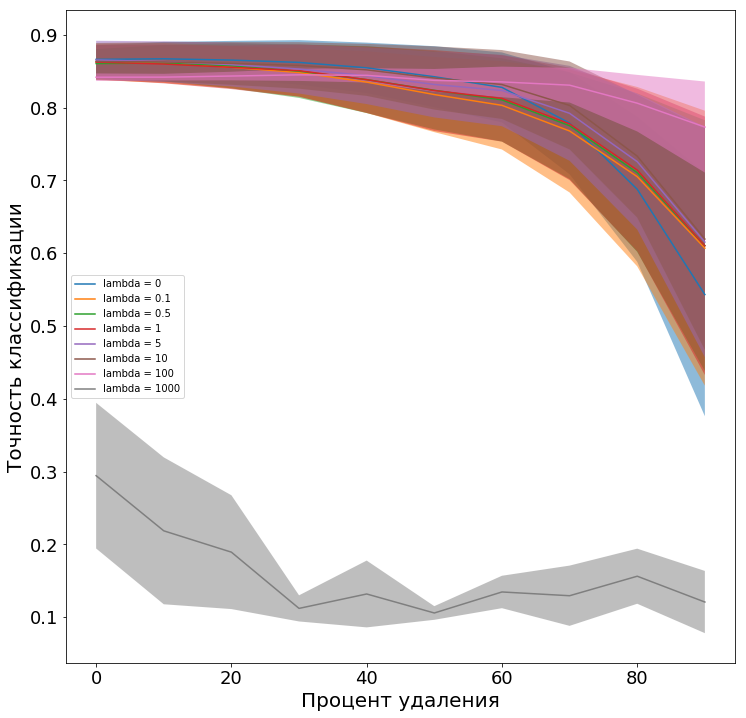

In [50]:
filename = 'lowrank3 + 1'
mode = 'frank'
lambda_sample_num = 1
epoch_num = 1
acc_delete = []

for k,lam in enumerate(lamb):
    nets = []
    optimizer_nets = []
    for i in range(len(old_nets)):
        new_net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
        for j in range(0, 2): # бежим по слоям
            lam_param = lam / 100
            new_net[j].mean.data*=0
            new_net[j].mean.data+=old_nets[i][j].mean(lam_param)
            new_net[j].mean_b.data*=0
            new_net[j].mean_b.data+=old_nets[i][j].mean_b(lam_param)
            new_net[j].log_sigma.data*=0
            new_net[j].log_sigma.data+=old_nets[i][j].log_sigma(lam_param)
            new_net[j].log_sigma_b.data*=0
            new_net[j].log_sigma_b.data+=old_nets[i][j].log_sigma_b(lam_param)
        nets.append(new_net)
        optimizer_nets.append(optim.Adam(nets[i].parameters(), lr=0.001)) # здесь уже можно и адама
    print(test_acc(init_nets_output[0]))
    train_nets(init_nets_output[0], init_nets_output[1], init_nets_output[2], init_nets_output[3], init_nets_output[4], lam)
    init_coeff(prune_coef_glob, mu_glob, sigma_glob)   
    acc_delete.append(None)
    acc_delete[k]= delete_10(acc_delete[k], prune_coef_glob, mu_glob, sigma_glob, nets, init_nets_output[0])
graph(acc_delete,lamb)
save(acc_delete)

In [72]:
old_nets

[VarSeqNet(
   (0): VarLayer()
   (1): VarLayer()
 ), VarSeqNet(
   (0): VarLayer()
   (1): VarLayer()
 ), VarSeqNet(
   (0): VarLayer()
   (1): VarLayer()
 )]